In [1]:
from math import log
import random
import numpy as np
import cvxpy as cp
from math import sqrt

In [2]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

plt.rcParams['font.size'] = 14.0
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams.update({'mathtext.default': 'regular' })

### Create problem

In [3]:
def sgn(x):
    return np.where(x < 0, -1, 1)

In [4]:
def create_K_piecewise_vector(m, n, rho=1., K=10, noise=1., seed=42):
    np.random.seed(seed)
    random.seed(seed)
    
    values = [np.random.randn(1) for _ in range(K)]
    cuts = np.sort(np.random.choice(np.arange(1, n), size=K-1, replace=False))
    parts = np.diff(np.concatenate(([0], cuts, [n])))
    x_pcw = np.repeat(values, parts)

    A = np.random.randn(m, n)

    e = noise * np.random.randn(m)

    b = A @ x_pcw + e
    
    D = rho * ( np.eye(n - 1, n) - np.eye(n - 1, n, k=1) )
    
    return A, b, D, x_pcw

In [5]:
A, b, D, x = create_K_piecewise_vector(10, 30, 5)

### Functions

In [6]:
def f(x, A, b):
    return 0.5 * np.linalg.norm(A @ x - b)**2

In [7]:
def F(x, A, b, D):
    return f(x, A, b) + np.linalg.norm(D @ x, 1)

In [8]:
def subgrad_F(x, A, b, D):
    return A.T @ (A @ x - b) + D.T @ sgn(D @ x)

### Q1 / Q2 - CVX

In [9]:
def q1_cvx(A, b):
    x = cp.Variable(A.shape[1])
    
    prob = cp.Problem(
        cp.Minimize(
            0.5 * cp.norm2(A @ x - b)**2
        )
    )
    result = prob.solve()
    
    return x.value, prob.value

In [10]:
def q2_cvx(A, b, D):
    x = cp.Variable(A.shape[1])
    
    prob = cp.Problem(
        cp.Minimize(
            0.5 * cp.norm2(A @ x - b)**2 + cp.norm1(D @ x)
        )
    )
    result = prob.solve()
    
    return x.value, prob.value

In [11]:
m, n, K = 100, 100, 10

noise = 0.1

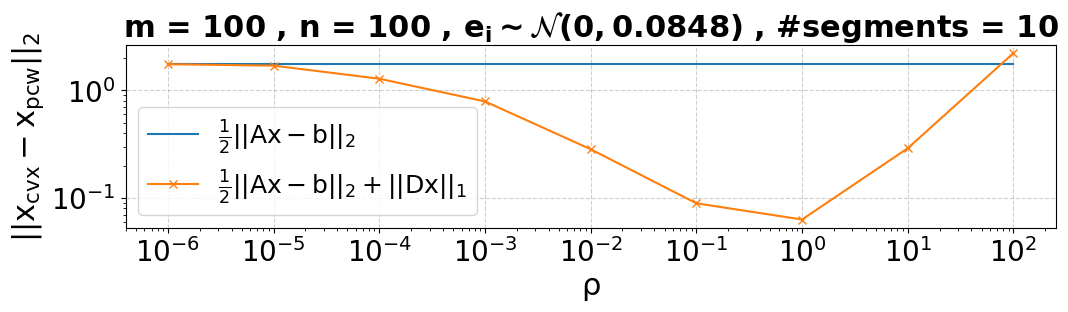

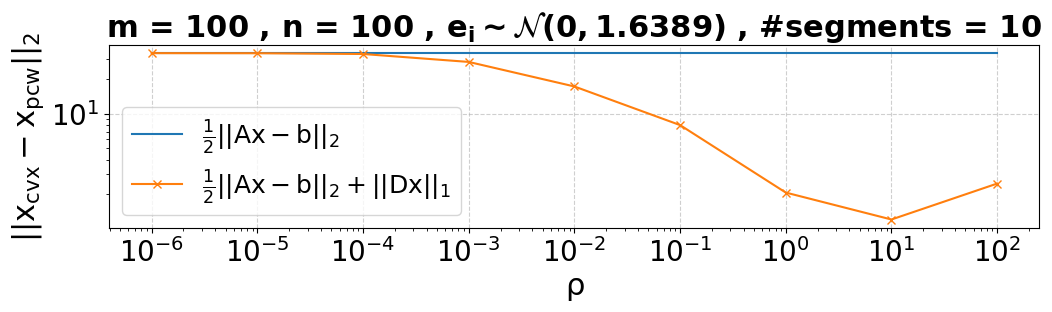

In [12]:
space = np.logspace(-6, 2, num=9)
e_space = np.logspace(-3, 1.5, num=15)

# 100 100 [0.0848, 1.6389]

for noise in [0.0848, 1.6389]:
    
    q1_diffs = []
        
    q2_diffs = []

    for rho in space:
        A, b, D, x_pcw = create_K_piecewise_vector(m, n, rho=rho, K=K, noise=noise)

        x_q1, _ = q1_cvx(A, b)
        q1_diffs.append(
            np.linalg.norm(x_q1 - x_pcw)
        )

        x_q2, _ = q2_cvx(A, b, D)
        q2_diffs.append(
            np.linalg.norm(x_q2 - x_pcw)
        )


    pdf = PdfPages(f'plots/2.4_ex_1-2_{rho:.2f}_{noise:.2f}.pdf')
    plt.figure(figsize=(12, 3))

    plt.plot(space, q1_diffs, label='$\\frac{1}{2} ||Ax - b||_2$')
    plt.plot(space, q2_diffs, label='$\\frac{1}{2} ||Ax - b||_2 + ||Dx||_1$', marker='x',)

    plt.grid(True, linestyle='--', alpha=0.6)

    plt.legend()

    # Label the axes
    plt.xlabel('$ρ$')
    plt.ylabel('$||x_{cvx} - x_{pcw} ||_2$')

    plt.xscale('log')
    plt.yscale('log')
    
    noise_str = "$e_i \\sim \\mathcal{N}(0, $"+f"{noise:.4f}"+")"

    plt.title(f"m = {m} , n = {n} , {noise_str} , #segments = {K}")

    plt.subplots_adjust(bottom=0.24, top=0.85)

    pdf.savefig(plt.gcf()) # Save the current figure
    plt.show()
    plt.close()
    pdf.close()

### Q3 - Q4

In [13]:
def T(x, tau):
    return np.sign(x) * np.maximum(np.abs(x) - tau, 0.0)

In [14]:
def subgrad_f(x, A, b):
    return A.T @ (A @ x - b)

In [15]:
def subgrad_descent(A, b, D, F_opt, max_k=100):
    
    n = A.shape[1]
    
    x = np.zeros(n)
    
    differences = []
    
    for k in range(max_k):
        
        g = subgrad_F(x, A, b, D)
        x = x - g / (sqrt(k+1) * np.linalg.norm(g))
        
        F_curr = F(x, A, b, D)
        differences.append(F_curr - F_opt)
        
    return differences

In [16]:
def s_fista(A, b, D, F_opt, max_k=100, epsilon=0.1):
    
    n = A.shape[1]
    
    D_spec = sqrt(max(np.linalg.eigvals(D.T @ D)))
    A_spec = sqrt(max(np.linalg.eigvals(A.T @ A)))
    A_T_A_spec = sqrt(max(np.linalg.eigvals( (A.T @ A).T @ (A.T @ A) )))
    
    mu = ( (2 * D_spec) / sqrt(n-1) ) * ( epsilon / (sqrt(D_spec**2 * (n-1)) + sqrt( D_spec**2 * (n-1) + 2*A_T_A_spec*epsilon)) )
    
    L = A_spec**2 + D_spec**2 / mu
    
    x = np.zeros(n)
    y = x
    
    t = 1
    
    differences = []
    
    for k in range(max_k):
        
        x_old = x
        x = y - (1/L) * (subgrad_f(y, A, b) + (1/mu) * D.T @ (D @ y - T(D @ y, mu)))
        
        t_old = t
        t = (1 + sqrt(1 + 4 * t**2)) / 2
        
        y = x + ( (t_old - 1) / t ) * (x - x_old)
        
        F_curr = F(x, A, b, D)
        differences.append(abs(F_curr - F_opt))
        
    return differences

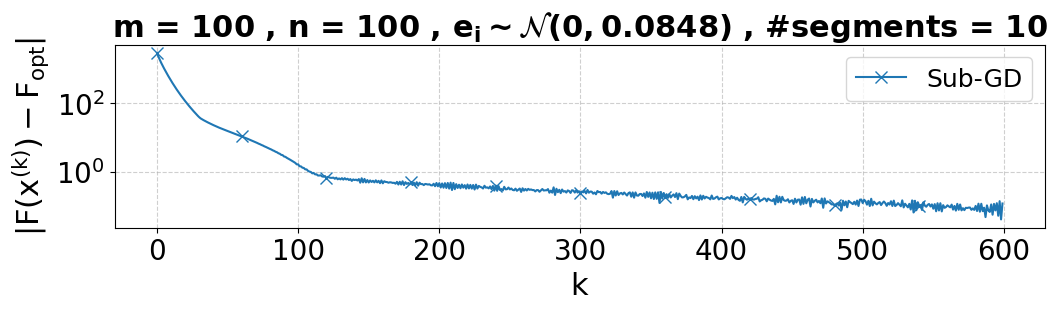

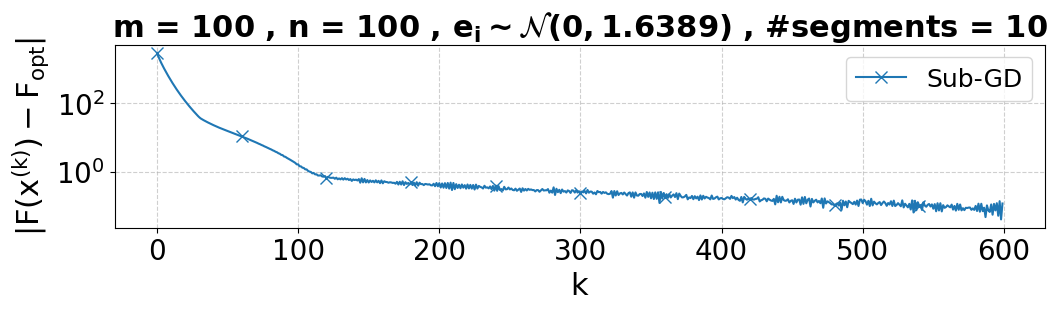

In [29]:
m, n, K = 100, 100, 10

noise = 0.1
rho = 1.
K = 10
#[0.0848, 1.6389]
#[1., 10]
A, b, D, x_pcw = create_K_piecewise_vector(m, n, rho=rho, K=K, noise=noise)
F_opt = F(x_pcw, A, b, D)


for noise, rho, sfistaepsilon in zip([0.0848, 1.6389], [1., 10], [5, 5]):

    subgrad_diffs = subgrad_descent(A, b, D, F_opt, max_k=600)
    #sfista_diffs = s_fista(A, b, D, F_opt, epsilon=sfistaepsilon, max_k=10000)

    pdf = PdfPages(f'plots/2.4_ex_3-4_sgd_{rho:.2f}_{noise:.2f}.pdf')
    plt.figure(figsize=(12, 3))

    markevery=int(len(subgrad_diffs)/10)
    plt.plot(list(range(len(subgrad_diffs))), subgrad_diffs, label='Sub-GD', marker='x', markevery=markevery, ms=9)

    plt.grid(True, linestyle='--', alpha=0.6)

    plt.legend()

    # Label the axes
    plt.xlabel('$k$')
    plt.ylabel('$|F(x^{(k)}) - F_{opt}|$')

    #plt.xscale('log')
    plt.yscale('log')

    noise_str = "$e_i \\sim \\mathcal{N}(0, $"+f"{noise:.4f}"+")"

    plt.title(f"m = {m} , n = {n} , {noise_str} , #segments = {K}")

    plt.subplots_adjust(bottom=0.24, top=0.85)

    pdf.savefig(plt.gcf()) # Save the current figure
    plt.show()
    plt.close()
    pdf.close()

In [30]:
(F_opt + subgrad_diffs[-1]) / F_opt

np.float64(1.0122698099686083)

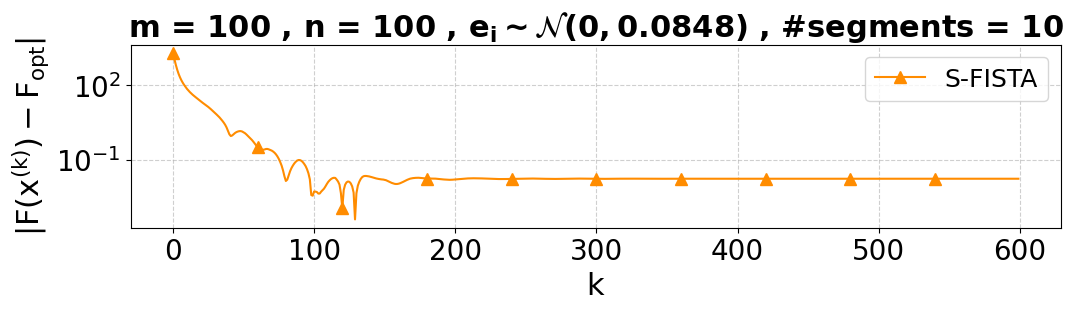

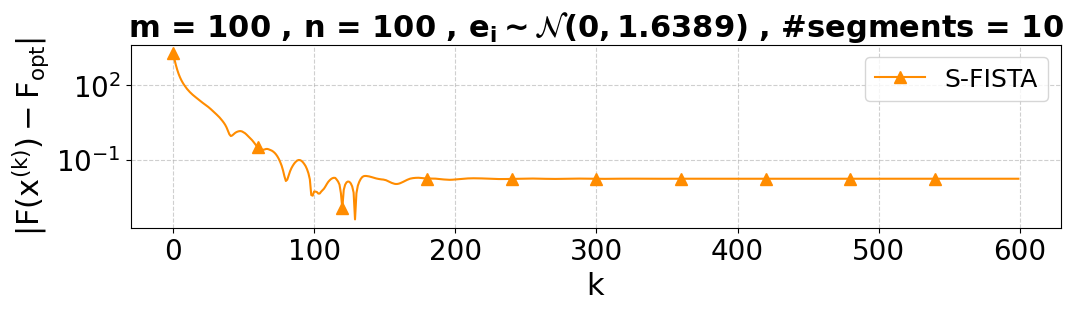

In [31]:
m, n, K = 100, 100, 10

noise = 0.1
rho = 1.
K = 10
#[0.0848, 1.6389]
#[1., 10]
A, b, D, x_pcw = create_K_piecewise_vector(m, n, rho=rho, K=K, noise=noise)
F_opt = F(x_pcw, A, b, D)


for noise, rho, sfistaepsilon in zip([0.0848, 1.6389], [1., 10], [5, 5]):

    #subgrad_diffs = subgrad_descent(A, b, D, F_opt, max_k=600)
    sfista_diffs = s_fista(A, b, D, F_opt, epsilon=sfistaepsilon, max_k=600)

    pdf = PdfPages(f'plots/2.4_ex_3-4_sfista_{rho:.2f}_{noise:.2f}.pdf')
    plt.figure(figsize=(12, 3))

    markevery=int(len(subgrad_diffs)/10)
    plt.plot(list(range(len(sfista_diffs))), sfista_diffs, label='S-FISTA', color='darkorange', marker='^', markevery=markevery, ms=9)

    plt.grid(True, linestyle='--', alpha=0.6)

    plt.legend()

    # Label the axes
    plt.xlabel('$k$')
    plt.ylabel('$|F(x^{(k)}) - F_{opt}|$')

    #plt.xscale('log')
    plt.yscale('log')

    noise_str = "$e_i \\sim \\mathcal{N}(0, $"+f"{noise:.4f}"+")"

    plt.title(f"m = {m} , n = {n} , {noise_str} , #segments = {K}")

    plt.subplots_adjust(bottom=0.24, top=0.85)

    pdf.savefig(plt.gcf()) # Save the current figure
    plt.show()
    plt.close()
    pdf.close()

In [32]:
sfista_diffs[-1]

np.float64(0.017421113354178175)

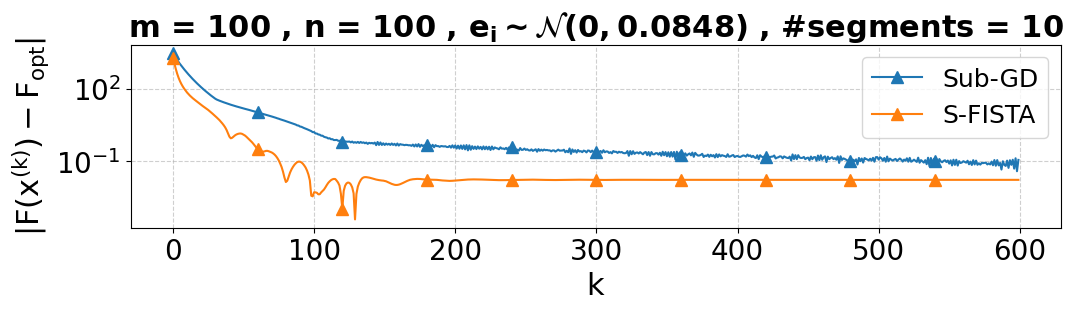

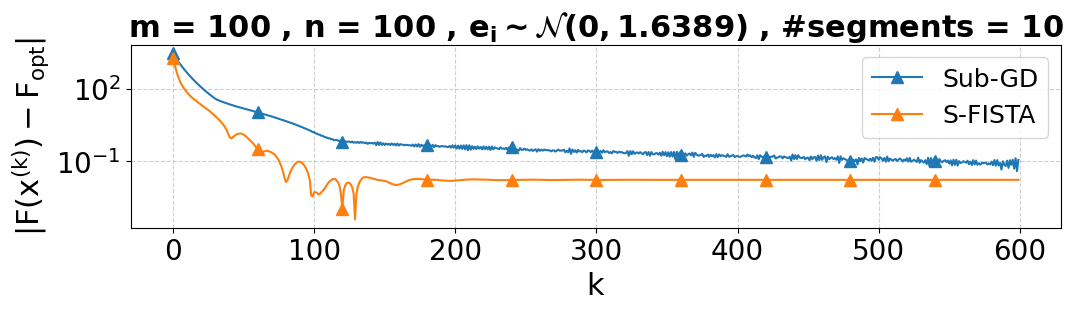

In [33]:
m, n, K = 100, 100, 10

noise = 0.1
rho = 1.
K = 10
#[0.0848, 1.6389]
#[1., 10]
A, b, D, x_pcw = create_K_piecewise_vector(m, n, rho=rho, K=K, noise=noise)
F_opt = F(x_pcw, A, b, D)


for noise, rho, sfistaepsilon in zip([0.0848, 1.6389], [1., 10], [5, 5]):

    subgrad_diffs = subgrad_descent(A, b, D, F_opt, max_k=600)
    sfista_diffs = s_fista(A, b, D, F_opt, epsilon=sfistaepsilon, max_k=600)

    pdf = PdfPages(f'plots/2.4_ex_3-4_vs_{rho:.2f}_{noise:.2f}.pdf')
    plt.figure(figsize=(12, 3))

    markevery=int(len(subgrad_diffs)/10)
    plt.plot(list(range(len(subgrad_diffs))), subgrad_diffs, label='Sub-GD', marker='^', markevery=markevery, ms=9)
    plt.plot(list(range(len(sfista_diffs))), sfista_diffs, label='S-FISTA', marker='^', markevery=markevery, ms=9)

    plt.grid(True, linestyle='--', alpha=0.6)

    plt.legend()

    # Label the axes
    plt.xlabel('$k$')
    plt.ylabel('$|F(x^{(k)}) - F_{opt}|$')

    #plt.xscale('log')
    plt.yscale('log')

    noise_str = "$e_i \\sim \\mathcal{N}(0, $"+f"{noise:.4f}"+")"

    plt.title(f"m = {m} , n = {n} , {noise_str} , #segments = {K}")

    plt.subplots_adjust(bottom=0.24, top=0.85)

    pdf.savefig(plt.gcf()) # Save the current figure
    plt.show()
    plt.close()
    pdf.close()